# Snake Cube

In [1]:
%matplotlib inline
%load_ext cython

import sys, os
import numpy as np
import pandas as pd
from timeit import default_timer as timer
from time import sleep

from math import ceil, sqrt

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
from matplotlib.path import Path
import matplotlib.patches as patches

from IPython.display import HTML, Image

np.set_printoptions(linewidth=200)
pd.set_option('display.width', 300)

###Introduction

A snake cube is a sequence of 27 small cubes connected by an elastic that goes through each cube. The elastic goes either straight through the cube, from one face to the opposite one, or turns inside the cube and goes from one face to an adjacent one. The aim of the game is to fold the snake into a 3x3x3 cube, if a solution exists. In technical terms such a solution is an undirected Hamiltonian path in the 3x3x3 grid graph.

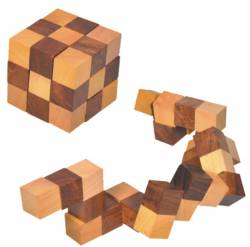

In [2]:
Image(os.path.join('img', 'SnakeCubeExample.jpg'))

###Objective

Our objective in this notebook is to solve any given snake cube and also to exhaustively search the space of all snake cubes: How many do have at least one solution ? What are their solutions exactly ? How to sort them out and make sense of how this population is distributed ?  

###Method

In the search special attention is paid to avoid counting the same snakes and/or solutions multiple times. Indeed a cube can be rotated into itself in 24 distinct ways. Each such rotated cube has 10 symmetrical positions (intial position + 9 axes of symmetry). And a snake is an unordered sequence of small cubes, so a snake and its reverse is the same object (when this is the case, we say the snake is palendromic).

A snake cube (or sequence) is represented as a list of 27 '0' or '1' - '1' for a turn small cube, and '0' for a straight small cube. The 2 end small cubes are conventionally set to '0'.

The class SnakeCube contains the search algorithm. This class can be used for either the search of solutions for a specific sequence (sequence is then the array of 27x{'0', '1'}), of the search of all possibles solutions and their corresponding sequences (sequence is left empty or contains a single element '0'). Note that even if we are interested in 3x3x3 cubes here, the algo works for any NxNxN cubes.

Given the nature of the task, the search is recursive. Most functions are quite self explanatory:  
+ solve()
+ start_search_from_all_positions()
+ start_from_position()
+ step()
+ branch()
+ turn()
+ is_valid_position()
+ is_within_cube()
+ is_position_vacant()
+ is_solution_complete()

####Cube Symmetries

In functions branch and turn, the search space in the cube is restricted (to take into accoun the many symmetries of the cube) by imposing the following constraints:  
1. Dimension n is not explored before dimension n+1
2. In any dimension the first move is in positive direction

Function keep_solution's purpose is to filter out duplicate solutions. Its dependent functions too are meant to be self explanatory:  
+ is_palendromic()
+ is_lexicographically_smaller_or_equal_than_reverse()
+ generate_reverse_direction()
+ create_direction_map()

####Snake Symmetries

While constraints (1) and (2) deal with the symmetries of the cube, keep_solution() deals with the symmetry of the snake (or sequence).

More specifically, when searching for the solutions of one sequence, all solutions are kept if the snake is not palendromic, otherwise only those solutions which are lexicographically smaller are kept. Because without this filter all solutions of a palendromic snake would appear twice in the results.

When the search is exhaustive in the whole snake cube space, every solution is bound to be discovered starting from both ends. So without filter all non palendromic solutions would be counted twice. This is why only the lexicographically smaller version of a solution is kept. We also keep a solution if it is lexicographically equal to its reverse to avoid filtering out solutions of palendromic snakes.

###Display Utilities

In [3]:
def css_styling():
    styles = '''<style>
    
    .dfsol { font-size: 11px; }
    .dfsol thead tr:last-child { background-color: #d9d9d9; }
    
    .dfstat { font-size: 11px; }
    .dfstat tbody tr td:last-child,
    .dfstat tbody tr td:nth-last-child(2),
    .dfstat tbody tr:last-child { background-color: #d9d9d9; }
    
    </style>'''    
    return HTML(styles+'<p>CSS added to web page in this output cell</p>')

css_styling()

###Snake Cube - Pure Python
+ Class SnakeCube contains the search algo

In [4]:
class SnakeCube(object):
    
    def __init__(self, N, sequence, verbose=False):
        self.N = N
        self.s = len(sequence)
        if (self.s==N**3):
                self.sequence = sequence
        else:
                self.sequence = np.zeros(N**3, dtype=np.int)
                self.sequence[:len(sequence)] = sequence
        self.all_solution = []
        self.verbose = verbose
        self.t0 = timer()

    
    def solve(self):
        print 'start solving'
        self.all_solution = []
        self.start_search_from_all_positions()
        
    
    def start_search_from_all_positions(self):
        for i in range(self.N):
            for j in range(self.N):
                for k in range(self.N):
                    if self.verbose:
                        print '\ninit_pos = {} {} {}\t = {:.2f} s\t'.format(i, j, k, timer()-self.t0)
                    self.start_from_position(i, j, k)

    
    def start_from_position(self, x, y, z):
        self.direction = np.zeros(self.N**3-1, dtype=np.int)
        self.solution = np.zeros([self.N, self.N, self.N], dtype=np.int)
        self.init_pos = np.array([x, y, z], dtype=np.int)
        self.solution[x, y, z] = 1
        self.step(0, self.init_pos.copy(), 1, 1)

     
    def step(self, n, pos, direct, explored_dim):
        sign = -1 if (direct<0) else 1
        new_pos = pos.copy()
        new_pos[abs(direct) - 1] += sign
        if self.is_valid_position(new_pos):
            self.branch(n+1, new_pos, direct, explored_dim)

    
    def branch(self, n, pos, direct, explored_dim):
        self.solution[pos[0], pos[1], pos[2]] = n+1
        self.direction[n-1] = direct

        if self.is_solution_complete(n):
            self.sequence[n] = 0
            if self.keep_solution():
#                 print 'solution no {}'.format(len(self.all_solution)+1)
                sys.stdout.write('\rsolution no = %d' % (len(self.all_solution)+1))
                sys.stdout.flush()
                self.all_solution.append({'sequence': self.sequence.copy(),
                                          'init_pos': self.init_pos,
                                          'direction': self.direction.copy(),
                                          'solution': self.solution.copy()})
        else:
            if (self.s<=n or self.sequence[n]==0):
                # go straight
                self.sequence[n] = 0
                self.step(n, pos.copy(), direct, explored_dim)
            if (self.s<=n or self.sequence[n]==1):
                # make a turn
                self.sequence[n] = 1
                self.turn(n, pos.copy(), direct, explored_dim)

        self.solution[pos[0], pos[1], pos[2]] = 0

    
    def turn(self, n, pos, direct, explored_dim):
        for k in range(1, min(explored_dim, 3)+1):
            if (k!=abs(direct)):
                self.step(n, pos.copy(), k, explored_dim)
                self.step(n, pos.copy(), -k, explored_dim)
        if (explored_dim<3):
            self.step(n, pos, explored_dim+1, explored_dim+1)

    
    def is_valid_position(self, position):
        return  self.is_within_cube(position) and self.is_position_vacant(position)

    
    def is_within_cube(self, pos):
        return set(pos).issubset(set(range(self.N)))

    
    def is_position_vacant(self, position):
        return self.solution[position[0], position[1], position[2]]==0

    
    def is_solution_complete(self, n):
        return (n==self.N**3-1)

    
    def keep_solution(self):
        if (self.s<=1):
            # exhaustive search
            return self.is_lexicographically_smaller_or_equal_than_reverse()
        elif (self.s==self.N**3):
            # search for one given snake
            return (not(self.is_palendromic()) or self.is_lexicographically_smaller_or_equal_than_reverse())
        else:
            # intermediary case: user decides what to do - provisionally no filter
            return True


    def is_palendromic(self):
        seq = self.sequence
        return (seq==seq[::-1]).all()


    def is_lexicographically_smaller_or_equal_than_reverse(self):
        # equal is important to avoid filtering out palendromic snakes in the full search
        reverse_direction = self.generate_reverse_direction()
        return (list(self.direction) <= list(reverse_direction))


    def generate_reverse_direction(self):
        direction_map = self.create_direction_map()
        rev_direction = direction_map[3+self.direction[::-1]]
        return rev_direction


    def create_direction_map(self):
        direction_map = np.zeros(3+1+3, dtype=np.int)
        explored_dim = np.zeros(3, dtype=np.int)
        reverse_direction = self.direction[::-1]
        i = 0
        d = 0
        while (d<3):
            k = abs(reverse_direction[i])
            if (explored_dim[k-1]==0):
                explored_dim[k-1] = 1
                d += 1
                direction_map[3+reverse_direction[i]] = d
                direction_map[3-reverse_direction[i]] = -d
            i += 1
        return direction_map


###Snake Cube - Cython
+ Class SnakeCube_C contains the search algo

In [5]:
%%cython -a

import cython
cimport cython

import numpy as np
cimport numpy as np

from timeit import default_timer as timer

from libc.math cimport pow, abs
from cython.view cimport array as cvarray

cdef inline int min(int a, int b): return a if a<b else b

#@cython.cdivision(True)

    
cdef class SnakeCube_C(object):
   
    # snake definition
    cdef long N
    cdef int s
    cdef int[:] sequence

    # search state variables
    cdef int[:] init_pos
    cdef int[:] direction
    cdef int[:, :, :] solution
    
    # stored search results
    cdef int no_sol
    cdef int no_sol_max
    cdef int[:, :] store_sequence
    cdef int[:, :] store_init_pos
    cdef int[:, :] store_direction
    cdef int[:, :, :, :] store_solution

    # intermediate variables
    cdef int[:] rev_sequence
    cdef int[:] rev_direction
    cdef int[:] direction_map
    cdef int[:] explored_dimension
    
    # display
    cdef int verbose
    cdef long t0
    

    property N:
        def __get__(self):
            return self.N

    property sequence:
        def __get__(self):
            return np.asarray(self.sequence)
        
    property s:
        def __get__(self):
            return self.s

    property no_sol:
        def __get__(self):
            return self.no_sol
        
    property store_init_pos:
        def __get__(self):
            return np.asarray(self.store_init_pos)
        
    property store_direction:
        def __get__(self):
            return np.asarray(self.store_direction)
        
    property store_solution:
        def __get__(self):
            return np.asarray(self.store_solution)
        
    property store_sequence:
        def __get__(self):
            return np.asarray(self.store_sequence)
          
    property verbose:
        def __get__(self):
            return self.verbose
          
    property t0:
        def __get__(self):
            return self.t0
          

    def __init__(self, int N, int[:] sequence, verbose=False):
        
        # snake definition
        self.N = N
        self.s = sequence.shape[0]

        if (self.s==self.N**3):
            self.sequence = sequence
        else:
            self.sequence = np.zeros(N**3, dtype=np.int32)
            self.sequence[:self.s] = sequence

        # search state variables
        self.init_pos = np.zeros(3, dtype=np.int32)
        self.direction = np.zeros(N**3-1, dtype=np.int32)
        self.solution = np.zeros([N, N, N], dtype=np.int32)
            
        # stored search results
        self.no_sol = 0
        self.no_sol_max = int(1e6)        
        self.store_sequence = np.zeros([self.no_sol_max, N**3], dtype=np.int32)
        self.store_init_pos = np.zeros([self.no_sol_max, 3], dtype=np.int32)
        self.store_direction = np.zeros([self.no_sol_max, N**3-1], dtype=np.int32)
        self.store_solution = np.zeros([self.no_sol_max, N, N, N], dtype=np.int32)
        
        
        # intermediate variables
        self.rev_sequence = np.zeros(N**3, dtype=np.int32)
        self.rev_direction = np.zeros(N**3-1, dtype=np.int32)
        self.direction_map = np.zeros(3+1+3, dtype=np.int32)
        self.explored_dimension = np.zeros(3, dtype=np.int32)
        
        self.verbose = verbose
        self.t0 = timer()
    
    
    def solve(self):
#         print 'Start Solving for\nN = {}\nsequence = {}'.format(self.N, np.asarray(self.sequence))
        print 'start solving'
        self.start_search_from_all_positions()
        # resize stores
        self.store_sequence = self.store_sequence[:self.no_sol]
        self.store_init_pos = self.store_init_pos[:self.no_sol]
        self.store_direction = self.store_direction[:self.no_sol]
        self.store_solution = self.store_solution[:self.no_sol]
        print '\nNumber of solutions = {}'.format(self.no_sol)


    cdef void start_search_from_all_positions(self):
        for i in range(self.N):
            for j in range(self.N):
                for k in range(self.N):
                    if self.verbose:
                        print '\ninit_pos={},{},{}\tt={:.2f} s'.format(i, j, k, timer()-self.t0)
                    self.start_from_position(i, j, k)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void start_from_position(self, int x, int y, int z):
        cdef int[:] direction_mv = self.direction
        cdef int[:, :, :] solution_mv = self.solution
        cdef int[:] init_pos_mv = self.init_pos
        
        direction_mv[:] = 0
        solution_mv[:] = 0
        
        init_pos_mv[0] = x
        init_pos_mv[1] = y
        init_pos_mv[2] = z
        
        solution_mv[x, y, z] = 1
        
        cdef int[:] pos_copy = init_pos_mv.copy()
        self.step(0, pos_copy, 1, 1)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void step(self, int n, int[:] pos, int direct, int explored_dim):
        cdef int sign = -1 if (direct<0) else 1
        cdef int[:] new_pos = pos.copy()
        new_pos[abs(direct) - 1] += sign
        if self.is_valid_position(new_pos):
            self.branch(n+1, new_pos, direct, explored_dim)

            
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void branch(self, int n, int[:] pos, int direct, int explored_dim):
        cdef int[:] direction_mv = self.direction
        cdef int[:] sequence_mv = self.sequence
        cdef int[:, :, :] solution_mv = self.solution
        solution_mv[pos[0], pos[1], pos[2]] = n+1
        direction_mv[n-1] = direct
        cdef int[:] pos_copy_straight
        cdef int[:] pos_copy_turn

        if self.is_solution_complete(n):
            sequence_mv[n] = 0
            if self.keep_solution():
                #print 'solution no {}'.format(self.no_sol+1)
                self.record_solution()
        else:
            if n>=self.s or sequence_mv[n]==0:
                # go straight
                sequence_mv[n] = 0
                pos_copy_straight = pos.copy()
                self.step(n, pos_copy_straight, direct, explored_dim)
            if n>=self.s or sequence_mv[n]==1:
                # make a turn
                sequence_mv[n] = 1
                pos_copy_turn = pos.copy()
                self.turn(n, pos_copy_turn, direct, explored_dim)
        
        solution_mv[pos[0], pos[1], pos[2]] = 0


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void turn(self, int n, int[:] pos, int direct, int explored_dim):
        cdef int k
        cdef int[:] pos_copy = pos.copy()
        for k in range(1, min(explored_dim, 3)+1):
            if (k!=abs(direct)):
                self.step(n, pos_copy, k, explored_dim)
                self.step(n, pos_copy, -k, explored_dim)
        if (explored_dim<3):
            self.step(n, pos_copy, explored_dim+1, explored_dim+1)

            
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void record_solution(self):
        cdef int[:, :] store_sequence_mv = self.store_sequence
        cdef int[:, :] store_init_pos_mv = self.store_init_pos
        cdef int[:, :] store_direction_mv = self.store_direction
        cdef int[:, :, :, :] store_solution_mv = self.store_solution
        cdef int[:] sequence_mv = self.sequence
        cdef int[:] init_pos_mv = self.init_pos
        cdef int[:] direction_mv = self.direction
        cdef int[:, :, :] solution_mv = self.solution
        cdef int N = self.N
        cdef int i = self.no_sol
        
        
        # increase store size if full
        if self.no_sol==self.no_sol_max:
            print 'store size increase'
            store_sequence_mv = np.concatenate([self.store_sequence,
                                                np.zeros([self.no_sol_max, N**3], dtype=np.int32)])
            store_init_pos_mv = np.concatenate([self.store_init_pos,
                                                np.zeros([self.no_sol_max, 3], dtype=np.int32)])
            store_direction_mv = np.concatenate([self.store_direction,
                                                 np.zeros([self.no_sol_max, N**3-1], dtype=np.int32)])
            store_solution_mv = np.concatenate([self.store_solution,
                                                np.zeros([self.no_sol_max, N, N, N], dtype=np.int32)])
            self.no_sol_max += int(1e5)
        
        # store
        store_sequence_mv[i, :] = sequence_mv
        store_init_pos_mv[i, :] = init_pos_mv
        store_direction_mv[i, :] = direction_mv
        store_solution_mv[i, :, :, :] = solution_mv
        self.no_sol += 1
        if (self.no_sol%1000==0):
            print self.no_sol, 
        

        # display status
        #print 'solution no {}'.format(store_sequence.shape[0])
        #sys.stdout.write('\rsolution no = %d' % (len(all_solution)))
        #sys.stdout.flush()

                            
    cdef int is_valid_position(self, int[:] pos):
        cdef int t1, t2
        t1 = self.is_within_cube(pos)
        t2 = self.is_position_vacant(pos)
        return t1 & t2
#         return self.is_within_cube(pos) and self.is_position_vacant(pos)


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int is_within_cube(self, int[:] pos):
        cdef int x, y, z, N
        N = self.N
        x = pos[0]
        y = pos[1]
        z = pos[2]
        if (x>=0 and x<N and y>=0 and y<N and z>=0 and z<N):
            return 1
        else:
            return 0


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int is_position_vacant(self, int[:] pos):
        cdef int[:, :, :] solution_mv = self.solution
        if solution_mv[pos[0], pos[1], pos[2]]==0:
            return 1
        else:
            return 0


    cdef int is_solution_complete(self, int n):
        if n==self.N**3-1:
            return 1
        else:
            return 0

        
    cdef int keep_solution(self):
        if (self.s<=1):
            # exhaustive search
            return self.is_lexicographically_smaller_or_equal_than_reverse()
        elif (self.s==self.N**3):
            # search for one given snake
            return (not(self.is_palendromic()) or self.is_lexicographically_smaller_or_equal_than_reverse())
        else:
            # intermediary case: user decides what to do - provisionally no filter
            return 1

        
    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int is_palendromic(self):
        cdef int[:] sequence_mv = self.sequence
        cdef int[:] rev_sequence_mv = self.rev_sequence
        rev_sequence_mv[:] = sequence_mv[::-1]
        cdef int is_equal = 1
        cdef int i
        for i in range(sequence_mv.shape[0]):
            if sequence_mv[i] != rev_sequence_mv[i]:
                is_equal = 0
                break
        return is_equal


    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef int is_lexicographically_smaller_or_equal_than_reverse(self):
        # equal is important to avoid filtering out palendromic snakes in the full search
        self.generate_reverse_direction()
        cdef int[:] direction_mv = self.direction
        cdef int[:] rev_direction_mv = self.rev_direction        
        cdef int i
        for i in range(direction_mv.shape[0]):
            if direction_mv[i]<rev_direction_mv[i]:
                return 1
            elif direction_mv[i]>rev_direction_mv[i]:
                return 0
        return 1
    

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void generate_reverse_direction(self):
        self.create_direction_map()
        cdef int[:] direction_map_mv = self.direction_map
        cdef int[:] direction_mv = self.direction
        cdef int[:] rev_direction_mv = self.rev_direction
        rev_direction_mv[:] = direction_mv
        cdef int n = direction_mv.shape[0]
        cdef int i, p
        for i in range(n):
            p = 3+direction_mv[n-1-i]
            rev_direction_mv[i] = direction_map_mv[p]

    @cython.boundscheck(False)
    @cython.wraparound(False)
    cdef void create_direction_map(self):
        cdef int[:] direction_mv = self.direction
        cdef int[:] rev_direction_mv = self.rev_direction
        cdef int[:] direction_map_mv = self.direction_map
        cdef int[:] explored_dimension_mv = self.explored_dimension
        direction_map_mv[:] = 0
        explored_dimension_mv[:] = 0
        rev_direction_mv[:] = direction_mv[::-1]
        cdef int i = 0
        cdef int d = 0
        cdef int k = 0
        while d<3:
            k = abs(rev_direction_mv[i])
            if explored_dimension_mv[k-1]==0:
                explored_dimension_mv[k-1] = 1
                d += 1
                direction_map_mv[3+rev_direction_mv[i]] = d
                direction_map_mv[3-rev_direction_mv[i]] = -d
            i += 1

###First Tests

[Jaap's puzzle page](http://www.jaapsch.net/puzzles/snakecube.htm) shows many results as well as a number of standard (commercially available) snake cubes.

In his terminology, straight/corners/end small cubes are denoted with the letter S/C/E respectively.
So we convert to our notation based on '0' and '1' before using the Snake Cube class in the case of the search of solutions for a given snake.

In [8]:
def letter_to_seq(s):
    seq = np.zeros(len(s), dtype=np.int32)
    for k in range(1, len(seq)-1):
        seq[k] = 1 if s[k]=='C' else 0
    return seq

def string_to_letter(s):
    t = s.replace('0', 'S').replace('1', 'C')
    t = list(t)
    t[0] = 'E'
    t[-1] = 'E'
    return ''.join(t)

StandardCubes = \
{'KevsKubes': 'ESCCCSCSCCCCCCCCCCCCCSCSCCE',
'CubraGreen': 'ESCSCSCCSCSCSCCCCSCCSCCSCSE',
'CubraBlue': 'ESCSCSCSCCCCSCSCCCSCCSCCCSE',
'CubraRed': 'ESCCCCCCCCCSCCCCCCCSCSCCCCE',
'CubraOrange': 'ESCSCCCCSCCCCCCCCSCCCSCCCSE',
'CubraPurple': 'ECCCCSCSCCCCCCCCCCCSCSCCCCE'}

ColStandardCubes = \
{'KevsKubes': 'LightGray',
'CubraGreen': 'LightGreen',
'CubraBlue': 'LightBlue',
'CubraRed': 'Tomato',
'CubraOrange': 'LightSalmon',
'CubraPurple': 'Plum'}

###Let us check if
+ we get the same result as Japp.
+ the Python and Cython codes give the same results.

In [9]:
#PYTHON CLASS

N = 3
dic_snake_cube = {}

for key in StandardCubes: 
    name = key
    cube = StandardCubes[key]
    print '\n', name
    t0 = timer()
    seq = letter_to_seq(cube)
    print seq
    s = SnakeCube(N, seq)
    s.solve()
    dic_snake_cube[name] = {'sequence': [e['sequence'] for e in s.all_solution],
                            'init_pos': [e['init_pos'] for e in s.all_solution],
                            'direction': [e['direction'] for e in s.all_solution],
                            'solution': [e['solution'] for e in s.all_solution]}

    t1 = timer()
    print '\nrun time = {:.3f}s'.format(t1-t0)
    print 'nb solutions = {}'.format(len(dic_snake_cube[name]['solution']))
    


KevsKubes
[0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0]
start solving
solution no = 1
run time = 0.068s
nb solutions = 1

CubraPurple
[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]
start solving
solution no = 6
run time = 0.777s
nb solutions = 6

CubraOrange
[0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0]
start solving
solution no = 1
run time = 0.076s
nb solutions = 1

CubraBlue
[0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0]
start solving
solution no = 1
run time = 0.005s
nb solutions = 1

CubraGreen
[0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0]
start solving
solution no = 1
run time = 0.004s
nb solutions = 1

CubraRed
[0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]
start solving
solution no = 10
run time = 0.463s
nb solutions = 10


In [10]:
# CYTHON CLASS

N = 3
dic_snake_cube_C = {}

for key in StandardCubes: 
    name = key
    cube = StandardCubes[key]
    print '\n', name
    t0 = timer()
    seq = letter_to_seq(cube)
    print seq
    s = SnakeCube_C(N, seq)
    s.solve()
    dic_snake_cube_C[name] = {'sequence': s.store_sequence,
                              'init_pos': s.store_init_pos,
                              'direction': s.store_direction,
                              'solution': s.store_solution}
    t1 = timer()
    print '\nrun time = {:.3f}s'.format(t1-t0)
    print 'nb solutions = {}'.format(len(dic_snake_cube_C[name]['solution']))


KevsKubes
[0 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0]
Start Solving

Number of solutions = 1

run time = 0.019s
nb solutions = 1

CubraPurple
[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]
Start Solving

Number of solutions = 6

run time = 0.166s
nb solutions = 6

CubraOrange
[0 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 0 0]
Start Solving

Number of solutions = 1

run time = 0.017s
nb solutions = 1

CubraBlue
[0 0 1 0 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 0]
Start Solving

Number of solutions = 1

run time = 0.001s
nb solutions = 1

CubraGreen
[0 0 1 0 1 0 1 1 0 1 0 1 0 1 1 1 1 0 1 1 0 1 1 0 1 0 0]
Start Solving

Number of solutions = 1

run time = 0.001s
nb solutions = 1

CubraRed
[0 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0]
Start Solving

Number of solutions = 10

run time = 0.101s
nb solutions = 10


###Check Consistency

In [11]:
b = True
for name in dic_snake_cube.keys():
    all_sol = dic_snake_cube[name]
    all_sol_C = dic_snake_cube_C[name]
    if not np.allclose(all_sol['sequence'],  all_sol_C['sequence']):
        b=False
    if not np.allclose(all_sol['init_pos'],  all_sol_C['init_pos']):
        b=False
    if not np.allclose(all_sol['direction'],  all_sol_C['direction']):
        b=False
    if not np.allclose(all_sol['solution'],  all_sol_C['solution']):
        b=False

print "SnakeCube and SnakeCube_C give the same results on Jaap's samples ? {}".format(b)

SnakeCube and SnakeCube_C give the same results on Jaap's samples ? True


###Dataframe to store all solution for a sequence

A sequence corresponds to a a physical snake cube.

In [12]:
def string_to_letter(s):
    t = s.replace('0', 'S').replace('1', 'C')
    t = list(t)
    t[0] = 'E'
    t[-1] = 'E'
    return ''.join(t)

def array_to_string(seq, sep):
    return sep.join(map(str, seq))

def sol_to_string (sol):
    # flatten 3x3x3 array solution
    seq = sol.ravel()
    return ','.join(map(str, seq))

#def string_to_array(s):
#  return np.fromstring(s, dtype=np.int, sep=',')

def string_to_array(s):
        return np.fromstring(','.join([c for c in s]), dtype=np.int, sep=',')

def string_to_sol(s):
    # reshape flat solution to 3x3x3 array
    v = np.fromstring(s, dtype=np.int, sep=',')
    return v.reshape(3, 3, 3)

def lexicographical_version(seq):
    # convert the sequence into it smaller lexicographical order
    s = seq if seq<seq[::-1] else seq[::-1]
    return s

df_solution = {}
for name in StandardCubes:
    seq = [lexicographical_version(array_to_string(e, ''))
            for e in dic_snake_cube[name]['sequence']]
    
    flat_sol = [sol_to_string(e)
            for e in dic_snake_cube[name]['solution']]
    
    first_pos = [array_to_string(e, ',')
            for e in dic_snake_cube[name]['init_pos']]
    
    direct = [array_to_string(e, ',')
            for e in dic_snake_cube[name]['direction']]
        
    df_solution[name] = pd.DataFrame(data=np.array([flat_sol, first_pos, direct]).T,
                                index = range(1, len(flat_sol)+1),
                                columns=['flat solution', 'first position', 'direction'])
    df_solution[name].index.name = seq[0]
    
df_solution.keys()

['KevsKubes',
 'CubraPurple',
 'CubraOrange',
 'CubraBlue',
 'CubraGreen',
 'CubraRed']

For example, below is the dataframe for the CubraRed.

In [14]:
pd.options.display.max_colwidth=40

HTML(df_solution['CubraRed'].to_html(classes='dfsol'))

###Dataframe conventions

The index name is the sequence.  
The index is the solution no.  
The 'first position' column is the starting position of the solution.  
The 'direction' column is the successive direction followed by the solution.  
1/2/3 for x/y/z axis respectively in the positive direction and -1/-2/-3 in the negative direction.  
The flat solution column is the 3D position of the small cubes in a 3x3x3 cube, after flattening for convenience. If the i-th number in the list is k, that means the k-th small cube in the sequence is at position i. The correspondance between position i in the list and in a 3x3x3 cube is shown via an example.

For example below is the flat and 3d-array representation of the first solution in the dataframe for the CubraRed.

In [15]:
df = df_solution['CubraRed'].copy()
print df.ix[1, 'flat solution']
print
print string_to_sol(df.ix[1, 'flat solution'])

1,26,19,24,25,20,23,22,21,2,27,18,5,16,17,6,9,10,3,14,13,4,15,12,7,8,11

[[[ 1 26 19]
  [24 25 20]
  [23 22 21]]

 [[ 2 27 18]
  [ 5 16 17]
  [ 6  9 10]]

 [[ 3 14 13]
  [ 4 15 12]
  [ 7  8 11]]]


###Visualisation

Now let us visualise the solutions of the StandardCubes

####Snake Visualisation

In [16]:
def string_to_array(s):
    return np.fromstring(','.join([c for c in s]), dtype=np.int, sep=',')

def seq_to_pos(s):
    direction = np.cumsum(s)%2
    x = np.append(0, np.cumsum(1-direction[:-1]))
    y = np.append(0, np.cumsum(direction[:-1]))
    return x, y

def draw_sequence_2(s, col):
    seq = string_to_array(s)
    x, y = seq_to_pos(seq)
    pos = np.vstack([x, y]).T
    xmax, ymax = pos[-1, 0]+1, pos[-1, 1]+1
    fig = plt.figure(figsize=(5*xmax/14, 5*ymax/14.0), dpi=100)
    ax = fig.add_subplot(1, 1, 1, axisbg='w')
    for k, p in enumerate(pos):
        c = col if k%2==1 else 'w'
        rect = mpl.patches.Rectangle(p, 1, 1, facecolor=c, edgecolor='k', linewidth=1.5)
        ax.add_patch(rect)
        ax.text(p[0]+0.5, p[1]+0.5, str(1+k), fontsize=8, horizontalalignment='center', verticalalignment='center')
    plt.xlim([-0.1, xmax+0.1])
    plt.ylim([-0.1, ymax+0.1])
    ax.axis('off')
    #plt.savefig("sequence.png",bbox_inches='tight')
    plt.show()
    
def draw_sequence(s, col):
    u = sqrt(2.0)/2.0
    seq = string_to_array(s)
    x, y = seq_to_pos(seq)
    pos = np.vstack([x, y]).T
    xmax = (pos[-1, 0]+pos[-1, 1])*u+2*u
    ymin, ymax = np.min(pos[:, 1]-pos[:, 0])*u-u, np.max(pos[:, 1]-pos[:, 0])*u+u
    codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
    fig = plt.figure(figsize=(5*xmax/14, 5*(ymax-ymin)/14), dpi=150)
    ax = fig.add_subplot(1, 1, 1, axisbg='w')
    for k, p in enumerate(pos):
        c = col if k%2==1 else 'w'
        x0 = (p[0]+p[1])*u
        y0 = (p[1]-p[0])*u
        vertices = np.array([[x0, y0], [x0+u, y0+u], [x0+2*u, y0], [x0+u, y0-u], [x0, y0]])
        path = Path(vertices, codes)
        patch = patches.PathPatch(path, facecolor=c, edgecolor='k', linewidth=1.5)
        ax.add_patch(patch)
        ax.text(x0+u, y0, str(1+k), rotation=-45, fontsize=8, horizontalalignment='center', verticalalignment='center')
    ax.set_xlim(-0.1, xmax+0.1)
    ax.set_ylim(ymin-0.1, ymax+0.1)
    ax.axis('off')
    #plt.savefig("sequence.png",bbox_inches='tight')
    plt.show()

####Solution visualisation

In [17]:
def string_to_path(s):
    return np.argsort(string_to_sol(s).ravel())+1

def coord_to_node(coord):
    x, y, z = coord
    return 1+1*x+3*y+9*z

def node_to_coord(node):
    z = (node-1)/9
    y = (node-1-z*9)/3
    x = node-1-z*9-y*3
    return [x, y, z]

def draw_path(ax, p, n):
    #grid
    r = np.arange(3)
    xx, yy, zz = np.meshgrid(r, r, r)
    ax.scatter(xx, yy, zz, marker='o', color='gray', s=20, alpha=0.6)
    xx, yy = np.meshgrid(r, r)
    for z in range(3):
        ax.plot(xx, yy, z, zdir='z', color='gray', alpha=0.15)
    for z in range(3):
        ax.plot(yy, xx, z, zdir='y', color='gray', alpha=0.15)
    for z in range(3):
        ax.plot(xx, yy, z, zdir='x', color='gray', alpha=0.15)
    d = 0.08
    for x in range(3):
        for y in range(3):
            for z in range(3):
                ax.text(x+d, y+d, z+0, str(1+1*x+3*y+9*z), color='k', alpha=0.6, ha='left', size=8)
    plt.axis('off')
    ax.view_init(elev=15, azim=-77)
    ax.dist = 6

    #path
    coord = np.array(map(node_to_coord, p))
    x = coord[:, 0]
    y = coord[:, 1]
    z = coord[:, 2]
    ax.plot(x, y, z, zdir='z', color='red', alpha=0.85, linewidth=1.35)
    ax.scatter(coord[:, 0], coord[:, 1], coord[:, 2], marker='o', color='red', alpha=1.0, s=20)
    ax.scatter(coord[0, 0], coord[0, 1], coord[0, 2], marker='o', facecolor='red', edgecolor='k', linewidth=1.5, alpha=1.0, s=75)
    ax.scatter(coord[-1, 0], coord[-1, 1], coord[-1, 2], marker='o', facecolor='red', edgecolor='k', linewidth=1.5, alpha=1.0, s=75)
    ax.text2D(0.05, 0.95, str(n), size=11, transform=ax.transAxes)
    
def draw_path_series(ps):
    h = 4
    v = int(ceil(float(len(ps))/h))
    fig = plt.figure(figsize=(2.5*h, 2.5*v), dpi=200)
    for k in range(len(ps)):
        ax = fig.add_subplot(v, h, 1+k, projection='3d', axisbg='w')
        draw_path(ax, ps[k], 1+k)
    plt.show()

###Standard Cubes visualisations

Here we extract the information in the dataframes and show it graphically.  
Meaningful because there are few solutions.


KevsKubes sequence=
	001110101111111111111010110
	ESCCCSCSCCCCCCCCCCCCCSCSCCE


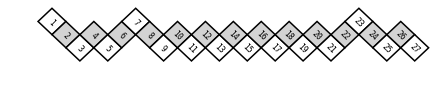

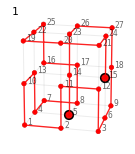


CubraPurple sequence=
	011110101111111111101011110
	ECCCCSCSCCCCCCCCCCCSCSCCCCE


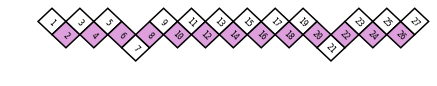

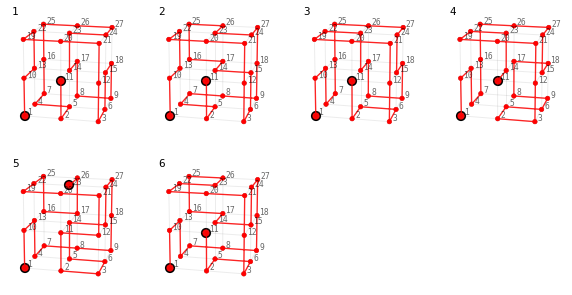


CubraOrange sequence=
	001011110111111110111011100
	ESCSCCCCSCCCCCCCCSCCCSCCCSE


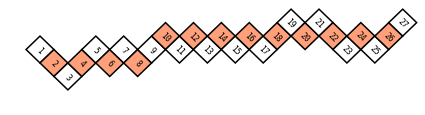

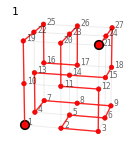


CubraBlue sequence=
	001010101111010111011011100
	ESCSCSCSCCCCSCSCCCSCCSCCCSE


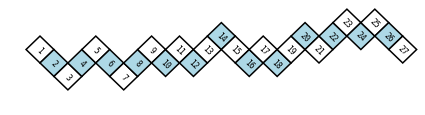

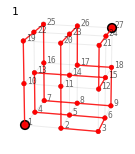


CubraGreen sequence=
	001010110101011110110110100
	ESCSCSCCSCSCSCCCCSCCSCCSCSE


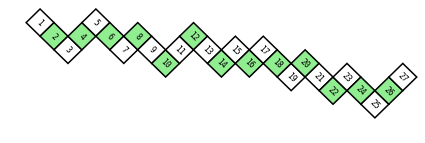

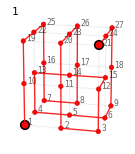


CubraRed sequence=
	001111111110111111101011110
	ESCCCCCCCCCSCCCCCCCSCSCCCCE


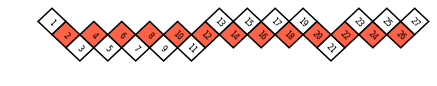

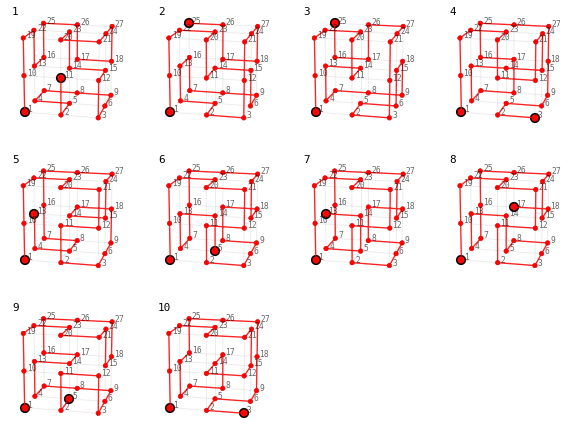

In [18]:
for key in StandardCubes:
    name = key
    df = df_solution[name].copy()
    print '\n{} sequence=\n\t{}\n\t{}'.format(name, df.index.name, string_to_letter(df.index.name))
    draw_sequence(df.index.name, ColStandardCubes[name])
    ps = map(string_to_path, df.ix[1:15, 'flat solution'])
    draw_path_series(ps)
    #sleep(2)

###Search all snake cube space - Python Class

Here we use the SnakeCube class to search all possible solutions and their corresponding snakes.  
The search time is about 530s on my machine and it finds __51,704__ solutions.  
The results are then stored in a dataframe.  

In [39]:
t0 = timer()

N = 3
seq = np.array([0])
snake_cube = SnakeCube(N, seq)
snake_cube.solve()

t1 = timer()
print '\nrun time = {:.2f}s'.format(t1-t0)

start solving
solution no = 51704
run time = 533.55s


###Search all snake cube space - Cython Class

The search time is about 140s on my machine.    

In [6]:
t0 = timer()

N = 3
seq = np.array([0], dtype=np.int32)
snake_cube_C = SnakeCube_C(N, seq, verbose=True)
snake_cube_C.solve()

t1 = timer()
print '\nrun time = {:.2f}s'.format(t1-t0)

Start Solving

init_pos=0,0,0	t=0.46 s
1000 2000 3000 4000 5000 6000 7000 8000 9000 10000 11000 12000 13000 14000 15000 16000 17000 18000 19000 20000 21000 22000 23000 24000 25000 26000 27000 28000 29000 30000 31000 32000 33000 34000 35000 36000 37000 38000 39000 
init_pos=0,0,1	t=50.31 s

init_pos=0,0,2	t=57.30 s

init_pos=0,1,0	t=57.30 s

init_pos=0,1,1	t=76.54 s
40000 41000 
init_pos=0,1,2	t=80.86 s

init_pos=0,2,0	t=80.86 s

init_pos=0,2,1	t=80.86 s

init_pos=0,2,2	t=80.86 s

init_pos=1,0,0	t=80.86 s

init_pos=1,0,1	t=117.88 s
42000 
init_pos=1,0,2	t=123.87 s

init_pos=1,1,0	t=123.87 s
43000 44000 45000 46000 47000 48000 49000 50000 51000 
init_pos=1,1,1	t=140.69 s

init_pos=1,1,2	t=144.52 s

init_pos=1,2,0	t=144.52 s

init_pos=1,2,1	t=144.52 s

init_pos=1,2,2	t=144.52 s

init_pos=2,0,0	t=144.52 s

init_pos=2,0,1	t=144.52 s

init_pos=2,0,2	t=144.52 s

init_pos=2,1,0	t=144.52 s

init_pos=2,1,1	t=144.52 s

init_pos=2,1,2	t=144.52 s

init_pos=2,2,0	t=144.52 s

init_pos=2,2,1	t=144.52 

In [65]:
# print snake_cube_C.store_sequence[0]
# print snake_cube_C.store_init_pos[0]
# print snake_cube_C.store_direction[0]
# print snake_cube_C.store_solution[0]

###Dataframe conventions

They are the same as those for individual sequence dataframes.  
Only there is an additional column, the sequence itself.

In [43]:
# PYTHON OBJECT
# seq = [lexicographical_version(array_to_string(e['sequence'], ''))
#         for e in snake_cube.all_solution]

# flat_sol = [sol_to_string(e['solution'])
#         for e in snake_cube.all_solution]

# first_pos = [array_to_string(e['init_pos'], ',')
#         for e in snake_cube.all_solution]

# direct = [array_to_string(e['direction'], ',')
#         for e in snake_cube.all_solution]

# df_raw_solution = pd.DataFrame(data=np.array([seq, flat_sol, first_pos, direct]).T,
#                                index = range(1, len(flat_sol)+1),
#                                columns=['sequence', 'flat solution', 'first position', 'direction'])
# df_raw_solution.to_pickle(os.path.join('data', 'df_raw_solution_python.pk'))

In [70]:
# CYTHON OBJECT
# seq = [lexicographical_version(array_to_string(e, ''))
#         for e in snake_cube_C.store_sequence]

# flat_sol = [sol_to_string(e)
#         for e in snake_cube_C.store_solution]

# first_pos = [array_to_string(e, ',')
#         for e in snake_cube_C.store_init_pos]

# direct = [array_to_string(e, ',')
#         for e in snake_cube_C.store_direction]

# df_raw_solution = pd.DataFrame(data=np.array([seq, flat_sol, first_pos, direct]).T,
#                                index = range(1, len(flat_sol)+1),
#                                columns=['sequence', 'flat solution', 'first position', 'direction'])
# df_raw_solution.to_pickle(os.path.join('data', 'df_raw_solution_cython.pk'))

###Load saved search results

Because the full search is relatively long, I load the results from the disk.

In [72]:
df_raw_solution = pd.read_pickle(os.path.join('data', 'df_raw_solution_cython.pk'))

In [73]:
pd.options.display.max_colwidth=30
pd.options.display.max_rows=12

df_raw_solution

sequence                  flat solution first position                      direction
1      001010111011101010110101010  1,22,17,8,23,16,7,24,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
2      001010111011101010110101010  1,26,17,8,25,16,7,24,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
3      001010111011101011110101010  1,20,17,8,21,16,7,22,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
4      001010111011101011111101010  1,18,17,8,27,16,7,26,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
5      001010111011101011010101110  1,18,17,8,19,16,7,20,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
6      001010111011101011010101110  1,18,17,8,19,16,7,20,15,2,...          0,0,0  1,1,2,2,-1,-1,-2,1,3,3,1,2...
...                            ...                            ...            ...                            ...
51699  011111101011111011111111110  11,12,15,20,19,16,21,18,17...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,-1,...
51700  011111101011111111101111110  11,12,21,14,13,20,15,18,19...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,-1,...
51701  011111101101101111101111110  21,22,13,20,23,14,19,16,15...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,3,3...
51702  011111101101101101101111110  19,18,13,20,17,14,21,16,15...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,3,3...
51703  011111101101101011111111110  15,14,13,16,23,22,17,20,21...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,3,3...
51704  011111101101101101101111110  15,14,13,16,17,18,21,20,19...          1,1,0  1,2,3,-2,3,-2,-3,-3,-1,3,3...

[51704 rows x 4 columns]

###Organising results

For easier readability and search, we add a few columns:  
+ Panlendromic: true or false
+ Number of solutions
+ Number of straight small cubes in the sequence

This operation takes about 17s on my machine

In [74]:
t0 = timer()

df = df_raw_solution.copy()
df.sort('sequence', inplace=True)
df.reset_index(drop=True, inplace=True)

def is_palendromic(seq):
    test = (seq==seq[::-1])
    return test

def nb_straight_in_seq(seq):
    n = (1-np.fromstring(','.join([c for c in seq]), dtype=np.int, sep=',')).sum()-2
    return n

def nb_solution_for_seq(seq):
    n = len(grouped.get_group(seq))
    return n

ref_cube = np.arange(1, 28).reshape(3, 3, 3)

def flat_sol_to_last_pos(fs):
    a = string_to_path(fs)
    i = np.where(a==27)[0][0]+1
    p = np.array(np.where(ref_cube==i)).flatten()
    ps = array_to_string(p, ',')
    return ps

df['palendromic'] = df['sequence'].apply(is_palendromic)
df['nb of straights'] = df['sequence'].apply(nb_straight_in_seq)
df['last position'] = df['flat solution'].apply(flat_sol_to_last_pos)

grouped = df.groupby('sequence')
df['nb of solutions'] = df['sequence'].apply(nb_solution_for_seq)

cols = ['sequence', 'nb of solutions', 'nb of straights', 'palendromic',
       'flat solution', 'first position', 'last position', 'direction']
df_full = df[cols]

print '\nrun time = {:.3f}s'.format(timer()-t0)

df_full.to_pickle(os.path.join('data', 'df_all_solution.pk'))


run time = 11.334s


In [75]:
df_full = pd.read_pickle(os.path.join('data', 'df_all_solution.pk'))

In [76]:
pd.options.display.max_colwidth=18
pd.options.display.max_rows=10

df = df_full.copy()
df

sequence  nb of solutions  nb of straights palendromic      flat solution first position last position          direction
0      00101010101010...                1               10       False  1,20,11,22,21,...          0,0,0         1,1,2  1,1,2,2,-1,-1,...
1      00101010101010...                2               10       False  1,16,15,26,25,...          0,0,0         1,0,1  1,1,2,2,-1,-1,...
2      00101010101010...                2               10       False  1,16,15,24,25,...          0,0,0         1,0,1  1,1,2,2,-1,-1,...
3      00101010101010...                1                9       False  1,20,11,22,21,...          0,0,0         1,1,2  1,1,2,2,-1,-1,...
4      00101010101010...                1               10       False  1,24,11,22,23,...          0,0,0         0,2,0  1,1,2,2,3,3,-2...
...                  ...              ...              ...         ...                ...            ...           ...                ...
51699  01111111111010...               18                2       False  1,18,17,4,19,1...          0,0,0         1,1,0  1,2,-1,2,3,1,-...
51700  01111111111010...               18                2       False  1,20,21,10,11,...          0,0,0         1,1,2  1,2,1,2,3,-1,-...
51701  01111111111010...               18                2       False  1,22,21,10,11,...          0,0,0         1,1,2  1,2,1,2,3,-1,-...
51702  01111111111010...               18                2       False  1,26,27,22,23,...          0,0,0         1,1,2  1,2,1,-2,3,2,3...
51703  01111111111010...               18                2       False  1,26,27,4,25,1...          0,0,0         1,1,0  1,2,-1,2,1,3,-...

[51704 rows x 8 columns]

###First observations

At this stage we can make a series of simple observations  
+ The ends of a solution always fall on a corner or a face, but never an edge or the center.
+ There are __11,487__ distinct snakes, for a total of __51,704__ solutions
+ The number of straigts varies from 2 to 11 included, so no snake is made of turns only

In [77]:
ends_list=list(set(list(set(df['last position']))+list(set(df['first position']))))
ends = np.array(map(string_to_array, ends_list))

# C=corner, E=edge, F=face, O=center
cubelets = np.array(['C', 'E', 'C', 'E', 'F', 'E', 'C', 'E', 'C', 'E', 'F', 'E', 'F', 'O', 'F', 'E', 'F', 'E', 'C', 'E', 'C', 'E', 'F', 'E', 'C', 'E', 'C'])
ref_cube_1 = cubelets.reshape(3,3,3)

set(map(lambda x: ref_cube_1[x[0], x[1], x[2]], ends))

{'C', 'E'}

In [78]:
len(set(df['sequence']))

11487

In [79]:
set(df['nb of straights'])

{2, 3, 4, 5, 6, 7, 8, 9, 10, 11}

###Overview of all solutions & snakes

In order to get an overview of the results, we aggregate the snakes by  
+ number of straights
+ number of solutions 

And put them in the dataframe below where:  
+ the top row is the number of straights in a solution
+ the leftmost column is the number of solutions for a snake
+ the rightmost column is the total number of solutions for any number of straights in the sequence
+ the bottom row is the total number of solutions with a given number of straights in the sequence

In [80]:
def create_df_stat(df):
    nbStraight_min = df['nb of straights'].min()
    nbStraight_max = df['nb of straights'].max()
    nbSol_min = df['nb of solutions'].min()
    nbSol_max = df['nb of solutions'].max()

    print 'nbStraight_min, nbStraight_max = {}, {}'.format(nbStraight_min, nbStraight_max)
    print 'nbSol_min, nbSol_max = {}, {}'.format(nbSol_min, nbSol_max)

    stats = np.zeros([nbSol_max-nbSol_min+1, nbStraight_max-nbStraight_min+1], dtype=np.int)
    for nSol in range(nbSol_max-nbSol_min+1):
        for nStr in range(nbStraight_max-nbStraight_min+1):
            stats[nSol, nStr] = np.logical_and(df['nb of solutions']==nbSol_min+nSol,
                                               df['nb of straights']==nbStraight_min+nStr).sum()/(nbSol_min+nSol)

    df_stat = pd.DataFrame(data=stats, index=range(nbSol_min, nbSol_max+1),
                           columns=range(nbStraight_min, nbStraight_max+1))
    df_stat = df_stat[df_stat.sum(axis=1)!=0]
    df_stat['sequence total'] = df_stat.sum(axis=1)
    df_stat['solution total'] = df_stat['sequence total']*df_stat.index
    df_stat = df_stat.append(pd.DataFrame(data=pd.DataFrame(df_stat.sum(axis=0)).T.values,
                                          index=['total'], columns=df_stat.columns))
    df_stat.columns.name='nb of straights'
    df_stat.index.name='nb of solutions'
    return df_stat

df_stat = create_df_stat(df)

#df_stat.to_pickle('df_stat.pd')
#df_stat.to_csv('df_stat.csv')

nbStraight_min, nbStraight_max = 2, 11
nbSol_min, nbSol_max = 1, 142


In [81]:
pd.options.display.max_colwidth=30
pd.options.display.max_rows=0

HTML(df_stat.to_html(classes='dfstat'))

##Visual representation of the results

A colored overview of the dataframe will help.

In [82]:
def colored_view_df_stat(df_stat, size=(15, 25)):
    df_stat_light = df_stat.copy()
    del df_stat_light['sequence total']
    del df_stat_light['solution total']
    df_stat_light = df_stat_light.drop('total')
    df_stat_light = df_stat_light[:]
    rng_sol = np.array(df_stat_light.index, dtype=np.int)
    rng_str = np.array(df_stat_light.columns, dtype=np.int)
    arr_stat_light = np.array(df_stat_light)
    
    my_cmap = mpl.cm.jet_r
    my_cmap.set_under('w')
    
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(111)

    #img portion
    cax = ax.matshow(arr_stat_light, interpolation='nearest', cmap=my_cmap, vmin=0.5, alpha=0.65, aspect=0.5)
    fig.colorbar(cax)

    #text portion
    x_pos, y_pos = np.meshgrid(range(len(rng_sol)), range(len(rng_str)))
    for x, y in zip(x_pos.flatten(), y_pos.flatten()):
        v = arr_stat_light[x, y]
        ax.text(y, x, v, va='center', ha='center')

    ax.grid(False)
    ax.set_xlabel('Nb Straights')
    ax.set_ylabel('Nb Solutions')

    xLabelPositions = range(len(rng_str))
    xNewLabels = rng_str
    plt.xticks(xLabelPositions, xNewLabels)

    yLabelPositions = range(len(rng_sol))
    yNewLabels = rng_sol
    plt.yticks(yLabelPositions, yNewLabels)

    plt.show()

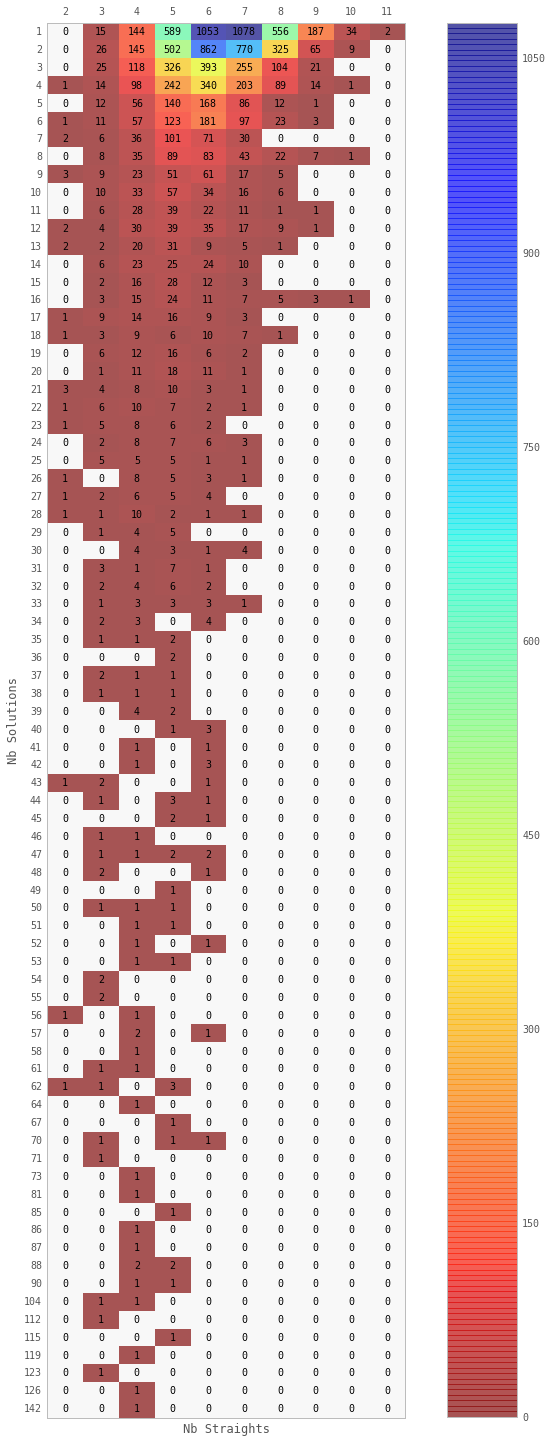

In [83]:
colored_view_df_stat(df_stat)

##Overview of all solutions & for palendromic snakes

This subset is special because particularly symmetric.  
The results are presented in the same format.

In [84]:
pd.options.display.max_colwidth=18
pd.options.display.max_rows=10

df = df_full.copy()
df_pal = df[df['palendromic']==True]
df_pal.reset_index(drop=True, inplace=True)
df_pal

sequence  nb of solutions  nb of straights palendromic      flat solution first position last position          direction
0    00101011011110...                1                9        True  1,18,23,16,17,...          0,0,0         2,2,2  1,1,2,2,-1,-1,...
1    00101011110111...                1                8        True  1,12,25,20,13,...          0,0,0         0,2,0  1,1,2,2,3,3,-2...
2    00101101111110...                4                7        True  1,22,23,16,21,...          0,0,0         2,2,2  1,1,2,2,3,-2,-...
3    00101101111110...                4                7        True  1,22,23,12,13,...          0,0,0         2,2,2  1,1,2,2,3,-1,-...
4    00101101111110...                4                7        True  1,22,23,10,9,2...          0,0,0         2,2,2  1,1,2,2,3,-1,-...
..                 ...              ...              ...         ...                ...            ...           ...                ...
408  01111111111010...               31                3        True  1,22,21,4,19,2...          0,0,0         1,1,2  1,2,-1,2,1,3,-...
409  01111111111010...               31                3        True  1,18,17,20,19,...          0,0,0         1,1,0  1,2,1,-2,3,-1,...
410  01111111111010...               31                3        True  21,20,13,18,19...          1,1,0         0,2,0  1,2,-1,3,1,3,-...
411  01111111111010...               31                3        True  15,14,13,8,9,1...          1,1,0         2,2,2  1,2,3,-1,-3,-1...
412  01111111111010...               31                3        True  15,14,13,8,9,1...          1,1,0         2,2,2  1,2,3,-1,-3,-1...

[413 rows x 8 columns]

In [85]:
df_stat_pal = create_df_stat(df_pal)

#df_stat_pal.to_pickle('df_stat_pal.pd')
#df_stat_pal.to_csv('df_stat_pal.csv')

nbStraight_min, nbStraight_max = 2, 10
nbSol_min, nbSol_max = 1, 45


In [86]:
pd.options.display.max_colwidth=30
pd.options.display.max_rows=0

HTML(df_stat_pal.to_html(classes='dfstat'))

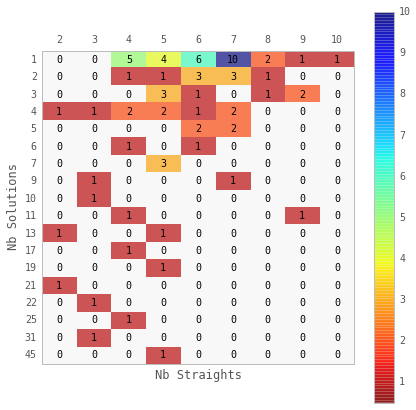

In [87]:
colored_view_df_stat(df_stat_pal, size=(7, 7))

##Additional remarks

How frequent are snake cubes ?  
The total number of candidate snake cubes is 2^25/2 = 16,777,216 (each small cube is either a straight or a turn, except the 2 ends, and a letter sequence and its reverse are the same snake).  
The number of plausible candidates snakes (meaning a snake that is such that it obviously cannot be folded into a 3x3x3 cube, i.e. a snake with 2 or more consecutive straights) is 98,209 (determined by brute force). Very Few (~0.5%) of all candidates are plausible snakes, but a decent number (~11.7%) of all plausible snakes are actual snake cubes.  
In other words, plausible candidates make it quite often.

In [88]:
t0 = timer()

def f(snake):
    if (len(snake)==25):
        return 1
    else:
        if (snake[-1]==0):
            res_straight = f(snake+[1])
        else:
            res_straight = 0
        res_turn = f(snake+[0])
        return res_straight+res_turn

nb_plausible_snakes = (f([0])+f([1]))/2

print '\nrun time = {:.3f}s'.format(timer()-t0)
print 'Nb Plausible Snakes = {}'.format(nb_plausible_snakes)


run time = 0.202s
Nb Plausible Snakes = 98209


##Examples

Below we give some outliers in the stat dataframes. 

The 15 snakes with 3 straights and unique solutions: 

In [89]:
df = df_full.copy()
df_sel = df.ix[np.logical_and(df['nb of solutions']==1, df['nb of straights']==3)]
string_series = df_sel['sequence']
print '{}\t{}\t\t\t{}'.format('No', 'sequence 0/1', 'sequence E/S/C')
for k, s in enumerate(string_series):
    print '{}\t{}\t{}'.format(1+k, s, string_to_letter(s))

No	sequence 0/1			sequence E/S/C
1	001110111111101111111111110	ESCCCSCCCCCCCSCCCCCCCCCCCCE
2	001110111111111111111011110	ESCCCSCCCCCCCCCCCCCCCSCCCCE
3	001111111011101111111111110	ESCCCCCCCSCCCSCCCCCCCCCCCCE
4	001111111101111111111111100	ESCCCCCCCCSCCCCCCCCCCCCCCSE
5	010110111111111111101111110	ECSCCSCCCCCCCCCCCCCSCCCCCCE
6	011011101111101111111111110	ECCSCCCSCCCCCSCCCCCCCCCCCCE
7	011110110111111110111111110	ECCCCSCCSCCCCCCCCSCCCCCCCCE
8	011110111011101111111111110	ECCCCSCCCSCCCSCCCCCCCCCCCCE
9	011110111011111110111111110	ECCCCSCCCSCCCCCCCSCCCCCCCCE
10	011110111110111011111111110	ECCCCSCCCCCSCCCSCCCCCCCCCCE
11	011110111111101110111111110	ECCCCSCCCCCCCSCCCSCCCCCCCCE
12	011110111111111011011111110	ECCCCSCCCCCCCCCSCCSCCCCCCCE
13	011111101110101111111111110	ECCCCCCSCCCSCSCCCCCCCCCCCCE
14	011111110110101111111111110	ECCCCCCCSCCSCSCCCCCCCCCCCCE
15	011111111010111011111111110	ECCCCCCCCSCSCCCSCCCCCCCCCCE


The palindromic snakes with unique solutions and the corresponding number of straights: 

In [90]:
df = df_full.copy()
df_sel = df[['sequence', 'nb of straights']].ix[np.logical_and(df['nb of solutions']==1, df['palendromic']==True)]
df_sel = df_sel.sort(columns='nb of straights', ascending=False)
df_sel.reset_index(inplace=True)
print '{}\t{}\t\t\t{}\t\t\t{}'.format('No', 'sequence 0/1', 'sequence E/S/C', 'Nb Straights')
for k, s in enumerate(df_sel['sequence']):
    print '{}\t{}\t{}\t{}'.format(1+k, s, string_to_letter(s), df_sel.ix[k, 'nb of straights'])

No	sequence 0/1			sequence E/S/C			Nb Straights
1	001101101011010110101101100	ESCCSCCSCSCCSCSCCSCSCCSCCSE	10
2	001010110111101111011010100	ESCSCSCCSCCCCSCCCCSCCSCSCSE	9
3	001101011011111110110101100	ESCCSCSCCSCCCCCCCSCCSCSCCSE	8
4	001010111101111101111010100	ESCSCSCCCCSCCCCCSCCCCSCSCSE	8
5	001111110110101011011111100	ESCCCCCCSCCSCSCSCCSCCCCCCSE	7
6	011110101011101110101011110	ECCCCSCSCSCCCSCCCSCSCSCCCCE	7
7	011011111010101010111110110	ECCSCCCCCSCSCSCSCSCCCCCSCCE	7
8	011010101111101111101010110	ECCSCSCSCCCCCSCCCCCSCSCSCCE	7
9	010111111010101010111111010	ECSCCCCCCSCSCSCSCSCCCCCCSCE	7
10	010111101011101110101111010	ECSCCCCSCSCCCSCCCSCSCCCCSCE	7
11	010110101111101111101011010	ECSCCSCSCCCCCSCCCCCSCSCCSCE	7
12	001111011011101110110111100	ESCCCCSCCSCCCSCCCSCCSCCCCSE	7
13	001011110111101111011110100	ESCSCCCCSCCCCSCCCCSCCCCSCSE	7
14	001101111110101011111101100	ESCCSCCCCCCSCSCSCCCCCCSCCSE	7
15	011010101111111111101010110	ECCSCSCSCCCCCCCCCCCSCSCSCCE	6
16	011110101101111101101011110	ECCCCSCSCCSCCC

The 10 snakes with most solutions and the corresponding number of straights: 

In [91]:
df = df_full[['sequence', 'nb of solutions', 'nb of straights']].copy()
grouped = df.groupby('sequence')
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
df = df.reindex(index)
df = df.sort(columns='nb of solutions', ascending=False)
df_sel = df[:10]
df_sel.reset_index(inplace=True)
print '{}\t{}\t\t\t{}\t\t\t{}\t{}'.format('No', 'sequence 0/1', 'sequence E/S/C', 'Nb Solutions', 'Nb Straights')
for k, s in enumerate(df_sel['sequence']):
    print '{}\t{}\t{}\t{}\t\t{}'.format(1+k, s, string_to_letter(s), df_sel.ix[k, 'nb of solutions'], df_sel.ix[k, 'nb of straights'])

No	sequence 0/1			sequence E/S/C			Nb Solutions	Nb Straights
1	011111101010101111111111110	ECCCCCCSCSCSCSCCCCCCCCCCCCE	142		4
2	011110101010111111111111110	ECCCCSCSCSCSCCCCCCCCCCCCCCE	126		4
3	001010111111111111111111110	ESCSCSCCCCCCCCCCCCCCCCCCCCE	123		3
4	001010101111111111111111110	ESCSCSCSCCCCCCCCCCCCCCCCCCE	119		4
5	001010101011111111111111110	ESCSCSCSCSCCCCCCCCCCCCCCCCE	115		5
6	011110101011111111111111110	ECCCCSCSCSCCCCCCCCCCCCCCCCE	112		3
7	011010101011111111111111110	ECCSCSCSCSCCCCCCCCCCCCCCCCE	104		4
8	001011111011111111111111110	ESCSCCCCCSCCCCCCCCCCCCCCCCE	104		3
9	001101101011111111111111110	ESCCSCCSCSCCCCCCCCCCCCCCCCE	90		4
10	011111101011011010111111110	ECCCCCCSCSCCSCCSCSCCCCCCCCE	90		5


The 11 palindromic snakes with most solutions and the corresponding number of straights

In [92]:
df = df_full[['sequence', 'nb of solutions', 'nb of straights', 'palendromic']].copy()
df = df[df['palendromic']==True]
grouped = df.groupby('sequence')
index = [gp_keys[0] for gp_keys in grouped.groups.values()]
df = df.reindex(index)
df = df.sort(columns='nb of solutions', ascending=False)
df_sel = df[:11]
df_sel.reset_index(inplace=True)
print '{}\t{}\t\t\t{}\t\t\t{}\t{}'.format('No', 'sequence 0/1', 'sequence E/S/C', 'Nb Solutions', 'Nb Straights')
for k, s in enumerate(df_sel['sequence']):
    print '{}\t{}\t{}\t{}\t\t{}'.format(1+k, s, string_to_letter(s), df_sel.ix[k, 'nb of solutions'], df_sel.ix[k, 'nb of straights'])

No	sequence 0/1			sequence E/S/C			Nb Solutions	Nb Straights
1	011111111010101010111111110	ECCCCCCCCSCSCSCSCSCCCCCCCCE	45		5
2	011111111110101011111111110	ECCCCCCCCCCSCSCSCCCCCCCCCCE	31		3
3	011111101011111110101111110	ECCCCCCSCSCCCCCCCSCSCCCCCCE	25		4
4	001111111111101111111111100	ESCCCCCCCCCCCSCCCCCCCCCCCSE	22		3
5	001111111111111111111111100	ESCCCCCCCCCCCCCCCCCCCCCCCSE	21		2
6	011111101101101101101111110	ECCCCCCSCCSCCSCCSCCSCCCCCCE	19		5
7	001011111111111111111110100	ESCSCCCCCCCCCCCCCCCCCCCSCSE	17		4
8	001111101111101111101111100	ESCCCCCSCCCCCSCCCCCSCCCCCSE	13		5
9	011110111111111111111011110	ECCCCSCCCCCCCCCCCCCCCSCCCCE	13		2
10	001101101101101101101101100	ESCCSCCSCCSCCSCCSCCSCCSCCSE	11		9
11	011010111111111111111010110	ECCSCSCCCCCCCCCCCCCCCSCSCCE	11		4
